# Interpreting SqueezeNet1.1 trained to detect defects in steel sheet 

### 1. Requirments

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch
import shap

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

from tqdm import tqdm
from torchvision import models
from torch import nn
#from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc

In [2]:
### Fast import of Captum Algorithm
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam
)

### 2. Parameters

In [3]:
MODEL_PATH = '../model/MultiAugmentedSqueezeReduced10.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/multiData'
METADATA_PATH = '../data/multiData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test.pth'

In [4]:
n_classes = 5
class_labels = {0: 'No Defects', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3', 4: 'Type 4'}

params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

### 3. Data
#### 3.1 Load data
Since retrieving all the batches using dataloader has been quite slow and created problem in Colab, a procedure to generate the full torch matrix (input, labels and masks) from the images should be performed to run this jupyter smoothly. If the INPUT, MASK and LABEL matrix are already present in the given paths we just load them

In [5]:
### Check if the given paths exists
if DATA_PATH.split('/')[1] not in os.listdir(DATA_PATH.split('/')[0]): # Create folder if it does not exists
    os.mkdir(DATA_PATH) 
c1 = INPUT_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c2 = LABEL_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c3 = MASK_PATH.split('/')[-1] in os.listdir(DATA_PATH)

In [6]:
### If the path are present we load the matrix, else we generate them
if c1 and c2 and c3:
    print('Data is present and ready to be loaded')
    X_test, y_test, M_test = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
else:
    print('Starting process to create matrices...')
    time.sleep(0.1)
    X_test, y_test, M_test = c_utils.create_data(IMAGE_PATH, METADATA_PATH, 
                                                 batch_size=200, num_workers=0, 
                                                 return_mask=True, params=params)

Data is present and ready to be loaded


#### 3.2 Visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


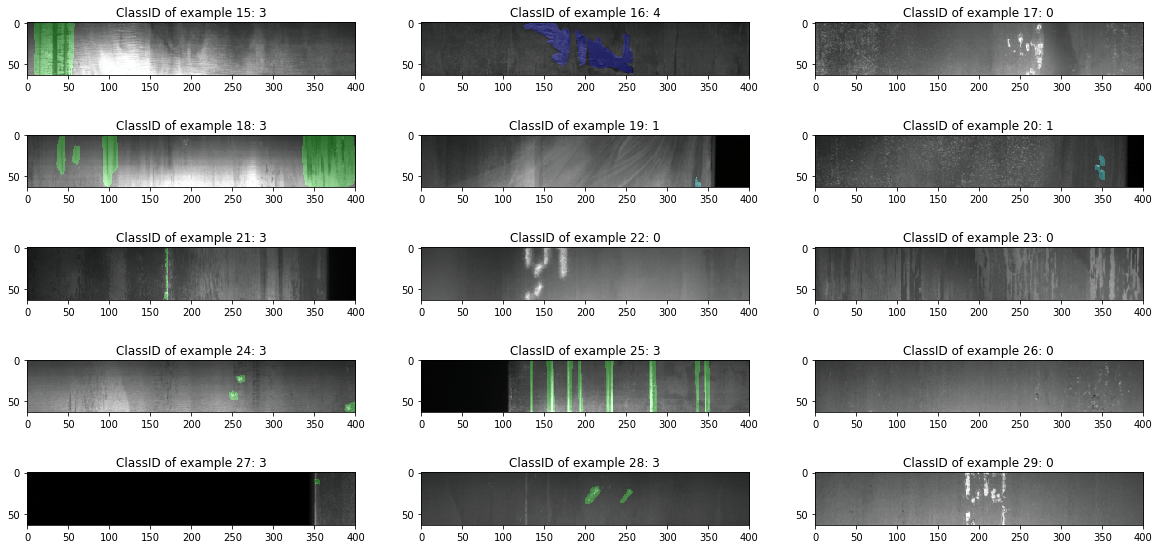

In [7]:
fig, ax = plt.subplots(5, 3, figsize=(20, 10))
start = 15
for i in range(start, start+15):
    img = np.transpose(X_test[i].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_test[i].reshape(*params['size'])
    if y_test[(i)] > 0:
        img[mask == 1] = img[mask == 1] + params['colors'][int(y_test[i])-1]
        
    ax[(i-start)//3, (i-start)%3].set_title('ClassID of example {}: {}'.format(i, y_test[i]))
    ax[(i-start)//3, (i-start)%3].imshow(img)
plt.show()

### 4. Model

    a) Load VGG architecture
    b) Modify the classifier architecture
    c) Load the parameters
    d) Move model in GPU

In [8]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
if 'Reduced8' in MODEL_PATH:
        net.features = net.features[:8]
        net.classifier[1] = nn.Conv2d(256, 1000, kernel_size = (1, 1), stride = (1, 1))
elif 'Reduced' in MODEL_PATH:
        net.features = net.features[:10]
        net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 5))#, nn.Softmax(dim=1))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [9]:
y_pred = []
y_true = []
y_score = torch.Tensor([])
batch_size = 20

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_test.shape[0]//batch_size)):
        X, y = X_test[n*batch_size:(n+1)*batch_size].to(device), y_test[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = out.detach().cpu()
        if type(net.classifier[-1]) != torch.nn.modules.activation.Softmax: 
            probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:08<00:00, 15.07it/s]


### 6. Interpretation

In [10]:
def visualize_input(n):
    fig, ax = plt.subplots(1, 1, figsize=(14, 5))
    img = np.transpose(X_test[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_test[n].reshape(*params['size'])
    img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[n])]
    ax.imshow(img)
    ax.set_title('True class: {}'.format(class_labels[int(y_true[n])]))

    print('The model predicted correctly:\t{}'.format(y_pred[n] == y_true[n]))
    print('Predicted No Defects with probability:\t{:.2f}'.format(y_score[n, 0]))
    print('Predicted Defects with probabability:\t{:.2f}'.format(y_score[n, 1]))
    plt.show()


def visualize_gradcam(n, module, out_type='id', normalizer=False, color_normalizer=True, return_output = False):
    ### 7.3.a) Show input image 
    fig = plt.figure(figsize = (13.3, 5))
    ax = fig.add_subplot(1, 1, 1)
    img = np.transpose(X_test[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_test[n].reshape(*params['size'])
    if y_true[n] > 0:
        img[mask == 1] = img[mask == 1] + params['colors'][int(y_true[n])-1]
    ax.imshow(img)
    
    ax.set_title('Input image')

    ### 7.3.b) Initialize GradCam passing the network and the last Convolutional Layer and the results tensor
    grad_cam = c_explainers.GradCam(net, module, device)
    results = torch.Tensor([])    

    ### 7.3.c) Compute GradCam for both target (No Defect/Defect)
    for i in range(n_classes):
        ### 7.3.c.i)  Compute Grad Cam with out_type 'id'. It means that no ReLU operation is done on the GradCam output
        _, original_out = grad_cam(X_test[n], i, out_type='id', interpolation_mode = cv2.INTER_LANCZOS4,  additional_out = True)
        ### 7.3.c.ii) Save the results
        grad_cam_output = cv2.resize(original_out.numpy(), (25*16, 4*16))
        results = torch.cat([results, torch.tensor(grad_cam_output).reshape(1, *list(grad_cam_output.shape))])

    ### 7.3.d) Normalize the results     
    if normalizer:
        gc_results = (results - torch.min(results)) / (torch.max(results) - torch.min(results))
    else:
        gc_results = results

    ### 7.3.e) Show GradCam outcomes
    fig = plt.figure(figsize = (16.8, 3.0*n_classes))                            ### Set figure                   
    for j in range(n_classes):          
        ax = fig.add_subplot(n_classes, 1, j+1)                                  ### Addsubplot to figure
        img_input = gc_results[j].numpy()                                        ### Get normalized GradCam output

        ### 7.3.e.i)  Define MidPointNormalizer to avoid automatic rescaling
        vmin, vmax = np.min(img_input), np.max(img_input)
        vmean = np.mean([vmin, vmax])                
        normalizer = c_utils.MidpointNormalize(vmin = vmin, vmax = vmax, vcenter = vmean)

        ### 7.3.e.ii) Plot GradCam outcome and colorbar
        if color_normalizer:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r, norm=normalizer)
        else:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r)
        plt.colorbar(img, ax=ax)
        ax.set_title('GradCAM: probability of {} = {:.3f}'.format(class_labels[j], float(y_score[n, j])))
    plt.show()
    return gc_results

def visualize_deeplift(n, normalizer=False, color_normalizer=True):
    ### 8.1.a) Show input image 
    fig = plt.figure(figsize = (13.3, 5))
    ax = fig.add_subplot(1, 1, 1)
    img = np.transpose(X_test[n].numpy(), (1, 2, 0))*params['std'] + params['mean']
    ax.imshow(img)
    ax.set_title('Input image')

    ### 8.1.b) Initialize DeepLift passing the network, initialize the baseline
    dl = DeepLift(net)
    baseline = torch.zeros((1, 3, 64, 400)).to(device)
    baseline.requires_grad = True
    results = torch.Tensor([])
    deltas = []

    ### 8.1.c) Compute DeepLift for both target (No Defect/Defect)
    for i in range(5):
        ### 8.1.c.i)  Perform DeepLift on input X (need to be resize in 4D) with the given baseline agaisnt output 'n' 
        output, delta = dl.attribute(X_test[n].view(1, *X_test[n].size()).to(device), baseline, i, return_convergence_delta=True)
        ### 8.1.c.ii) Save the results
        deltas.append(float(delta))
        results = torch.cat((results, output.view(1, 3, 64, 400).detach().cpu()))

    ### 8.1.d) Normalize the results
    if normalizer:
        dl_results = ((results - torch.min(results)) / (torch.max(results) - torch.min(results))).mean(dim=1)
    else:
        dl_results = results
        
        
    ## 8.1.d) Show DeepLift outcomes
    fig = plt.figure(figsize = (16.8, 6))                                        ### Set figure                   
    for j in range(5):
        ax = fig.add_subplot(2, 1, j+1)                                          ### Addsubplot to figure
        img_input = dl_results[j].numpy()                                        ### Get normalized DeepLift output

        ### 8.1.e.i)  Define MidPointNormalizer to avoid automatic rescaling
        vmin, vmax = np.min(img_input), np.max(img_input)
        vmean = np.mean([vmin, vmax])                
        normalizer = c_utils.MidpointNormalize(vmin = vmin, vmax = vmax, vcenter = vmean)

        ### 8.1.e.ii) Plot DeepLift outcome and colorbar
        if color_normalizer:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r, norm=normalizer)
        else:
            img = ax.imshow(img_input, cmap=plt.cm.RdBu_r)
        plt.colorbar(img, ax=ax)
        ax.set_title('DeepLift: probability of {} = {:.3f}'.format(class_labels[j], float(y_score[n, j])))
    plt.show()

### GradCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.0 3.0


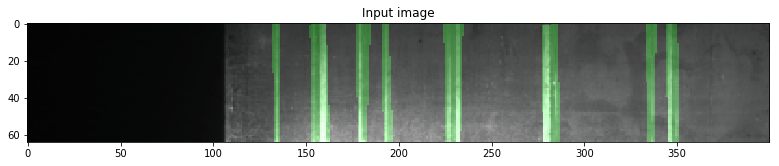

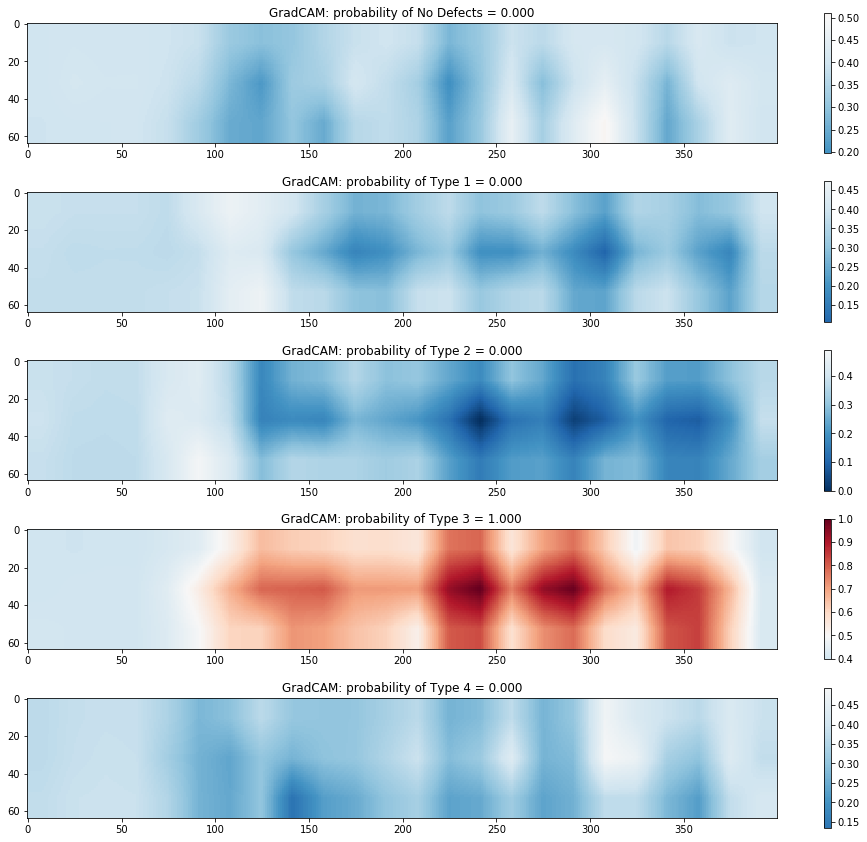

In [18]:
n = 25
print(y_true[n], y_pred[n])
res = visualize_gradcam(n, module = net.classifier[1], normalizer=True, color_normalizer=True, return_output=True)

The model predicted correctly:	True


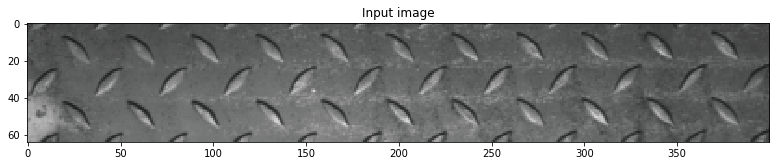

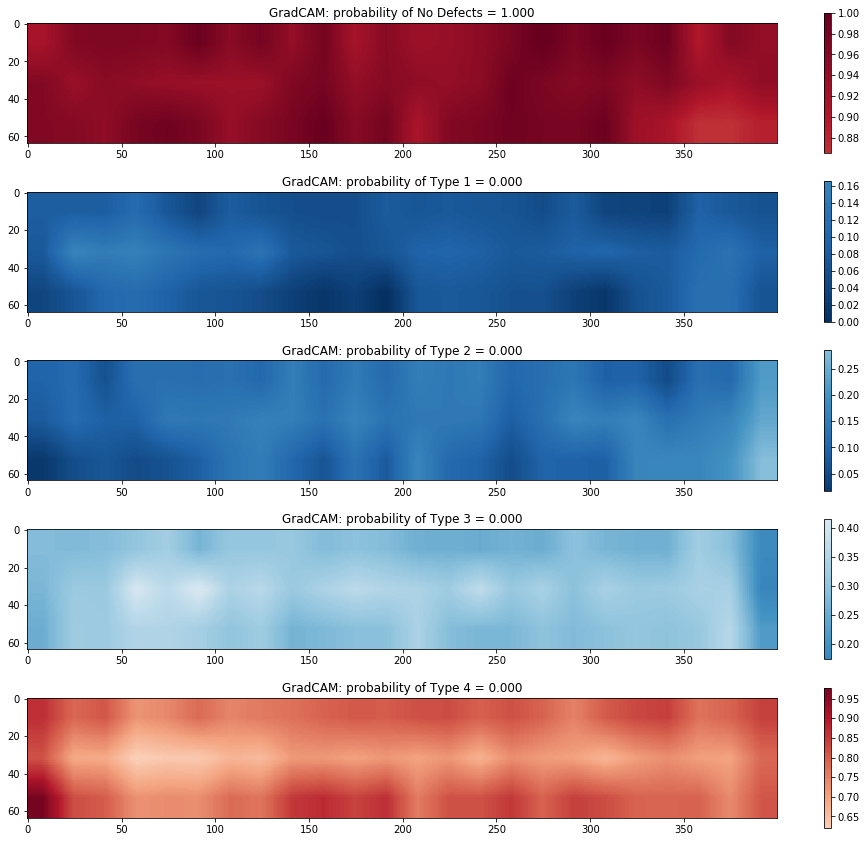

The model predicted correctly:	True


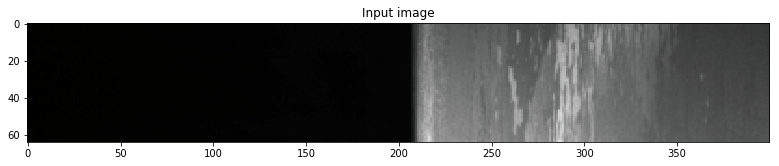

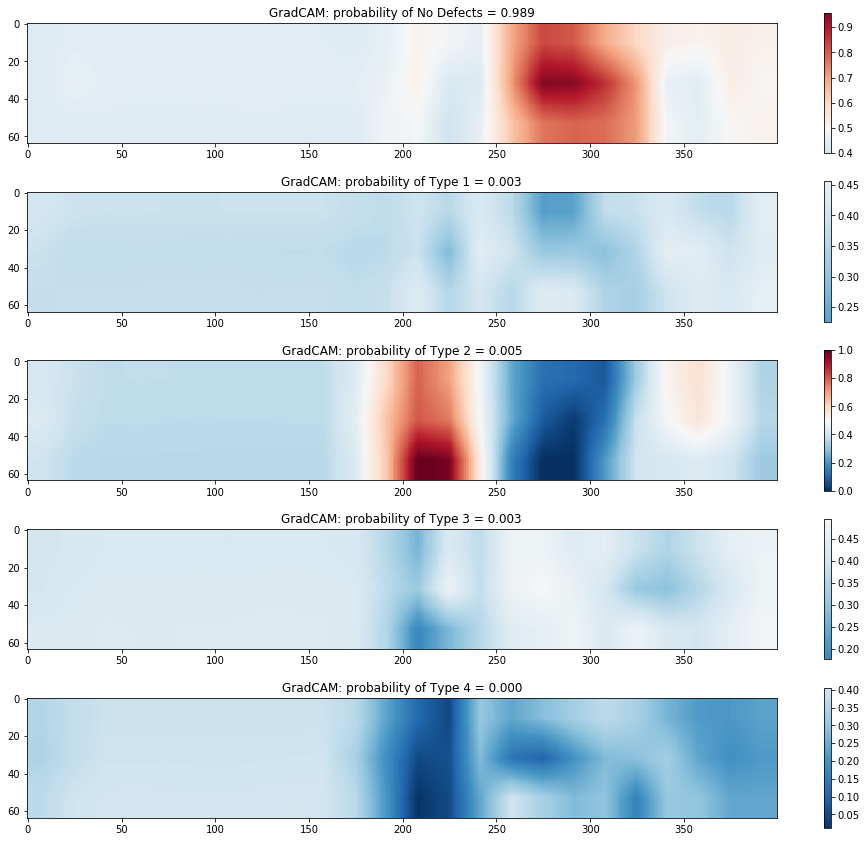

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True


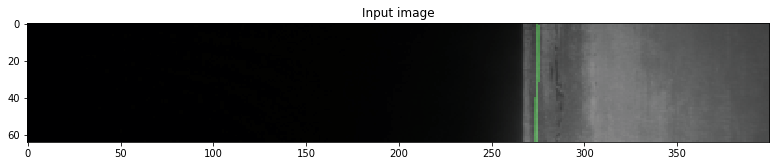

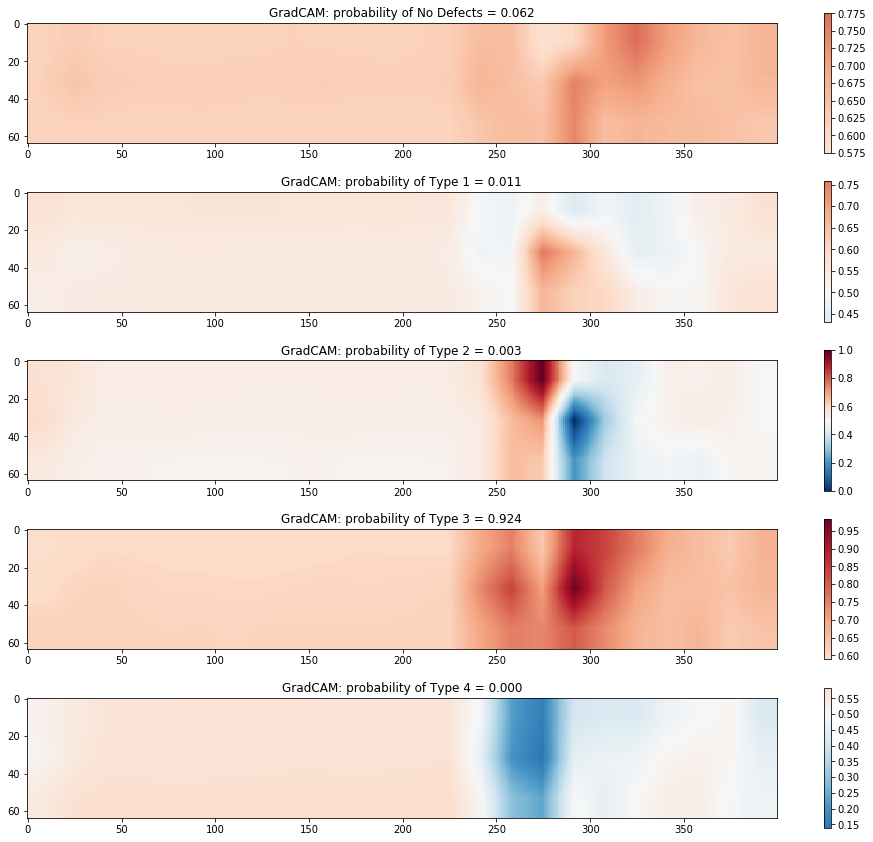

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True


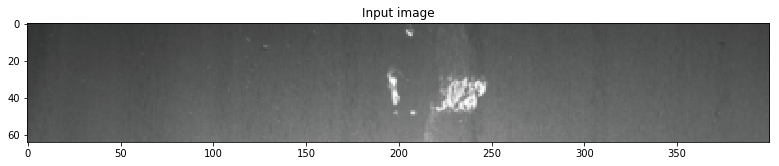

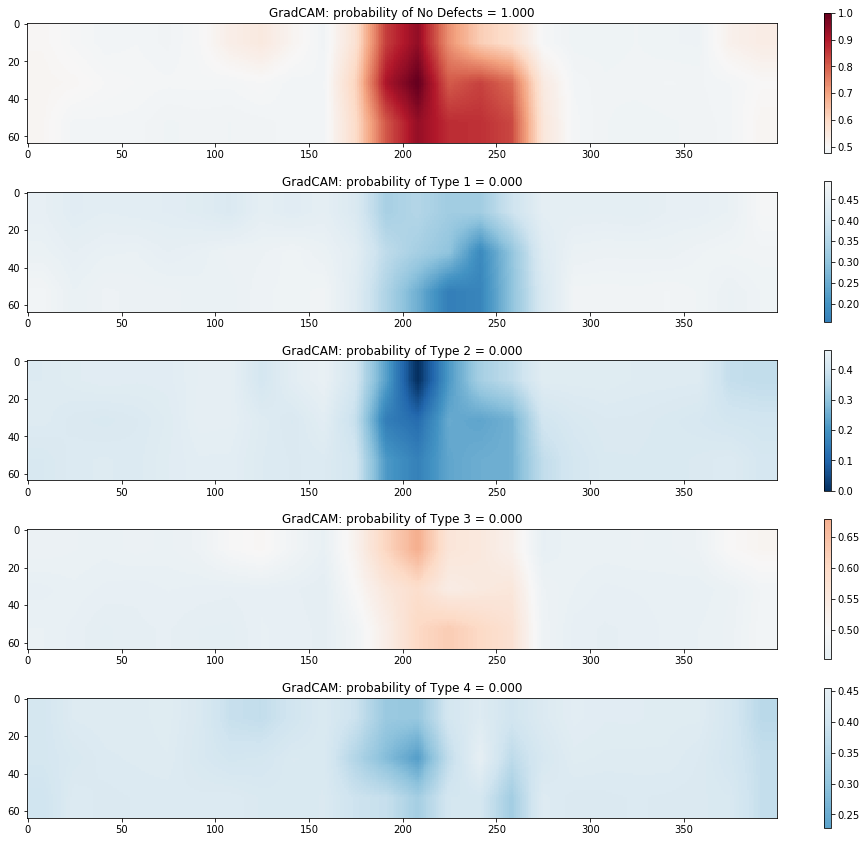

The model predicted correctly:	True


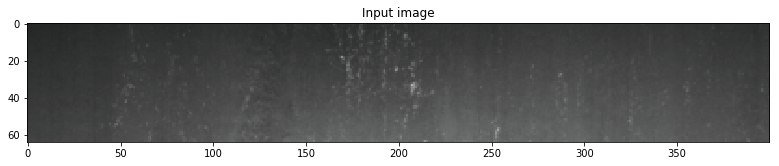

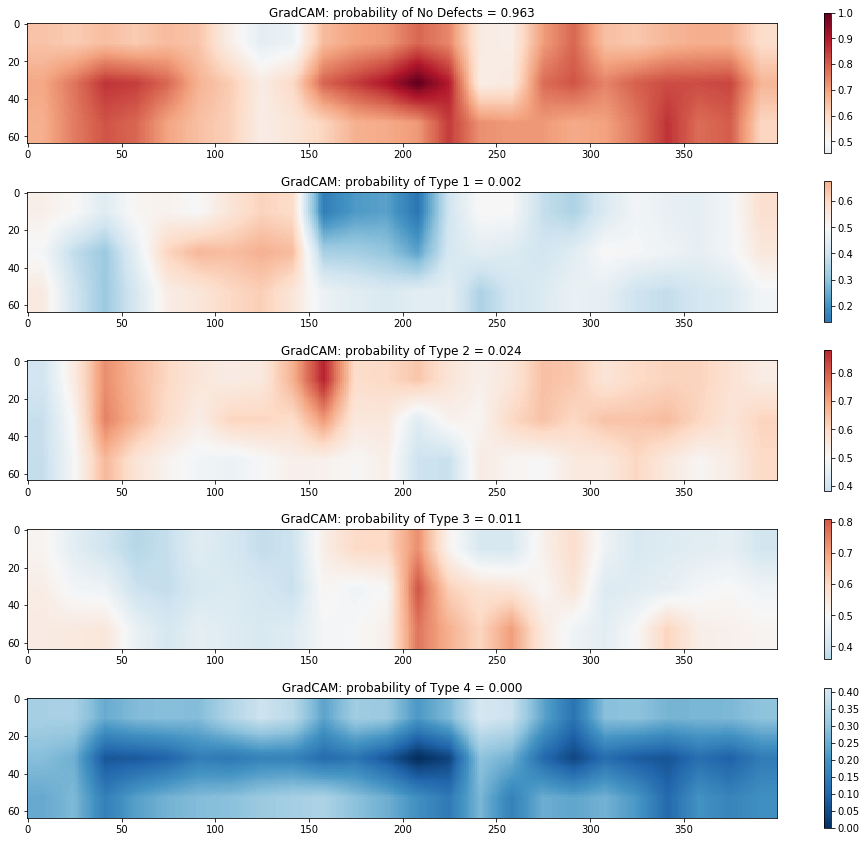

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True


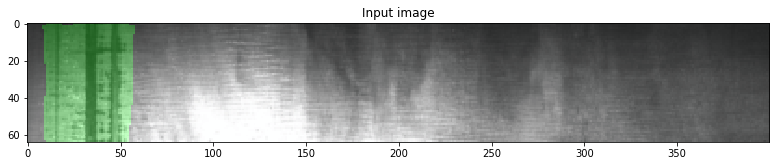

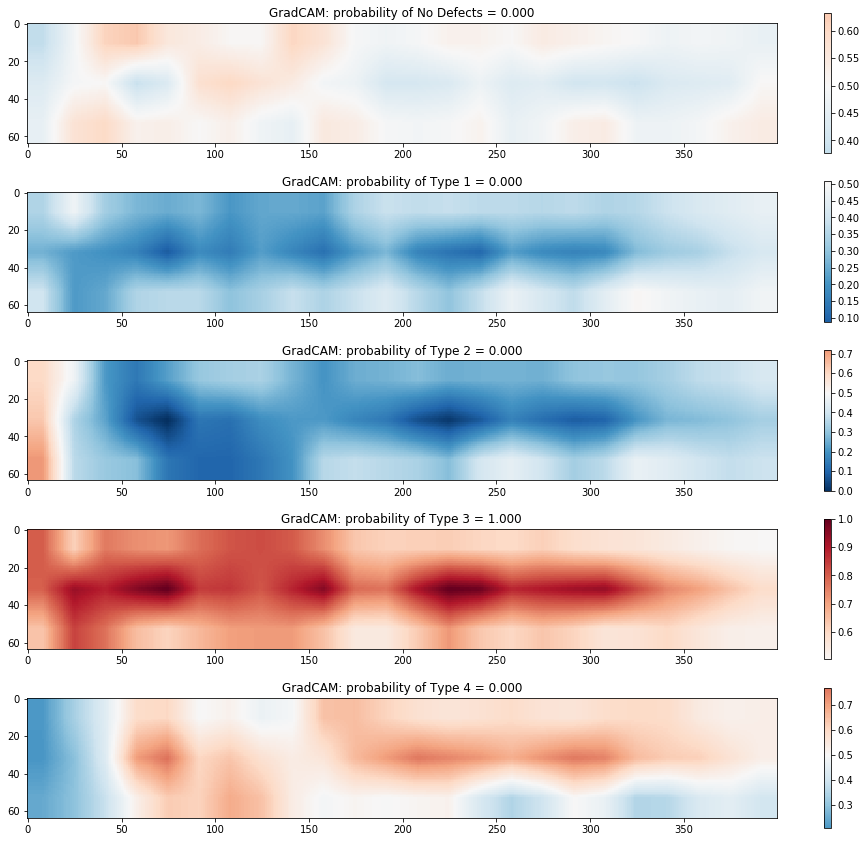

The model predicted correctly:	True


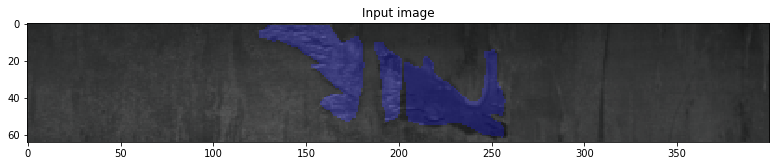

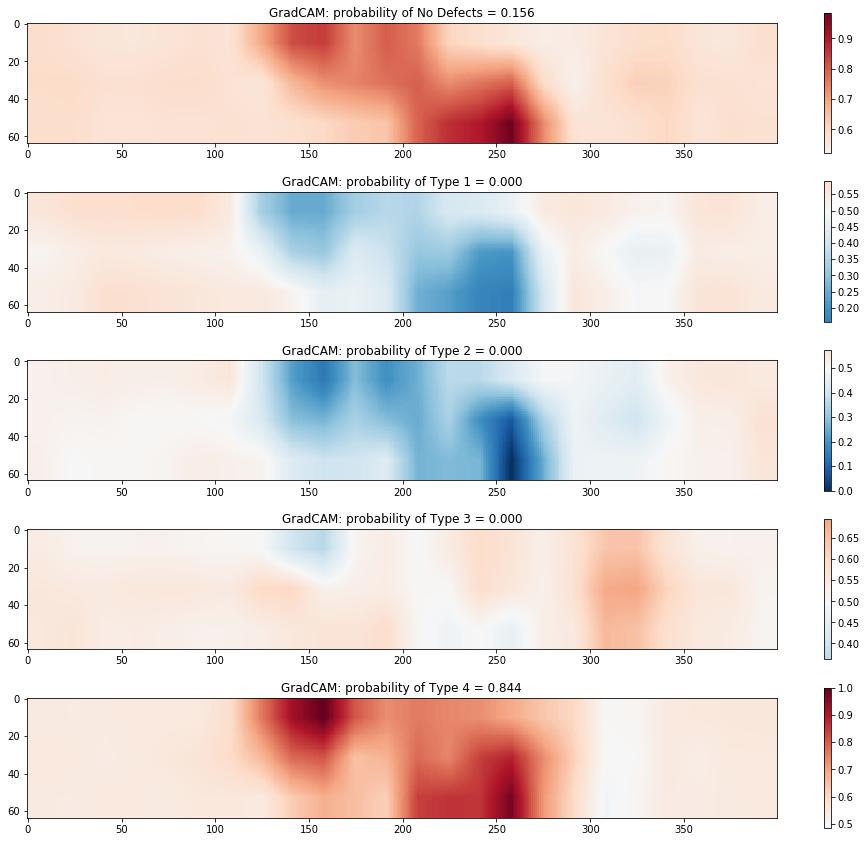

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True


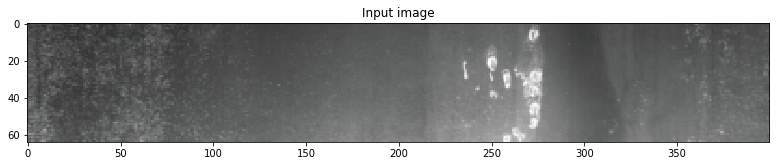

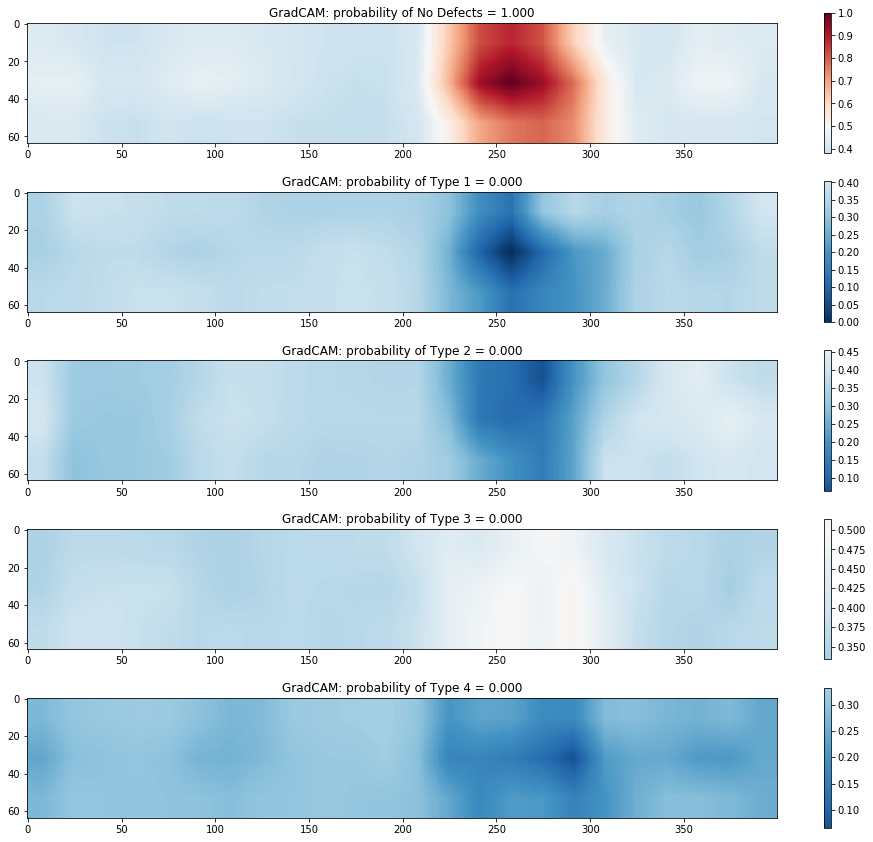

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True


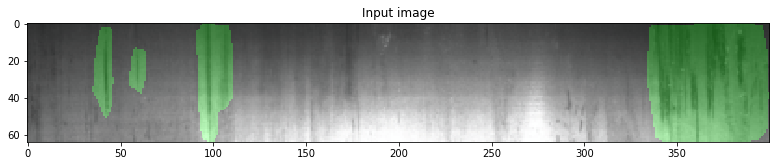

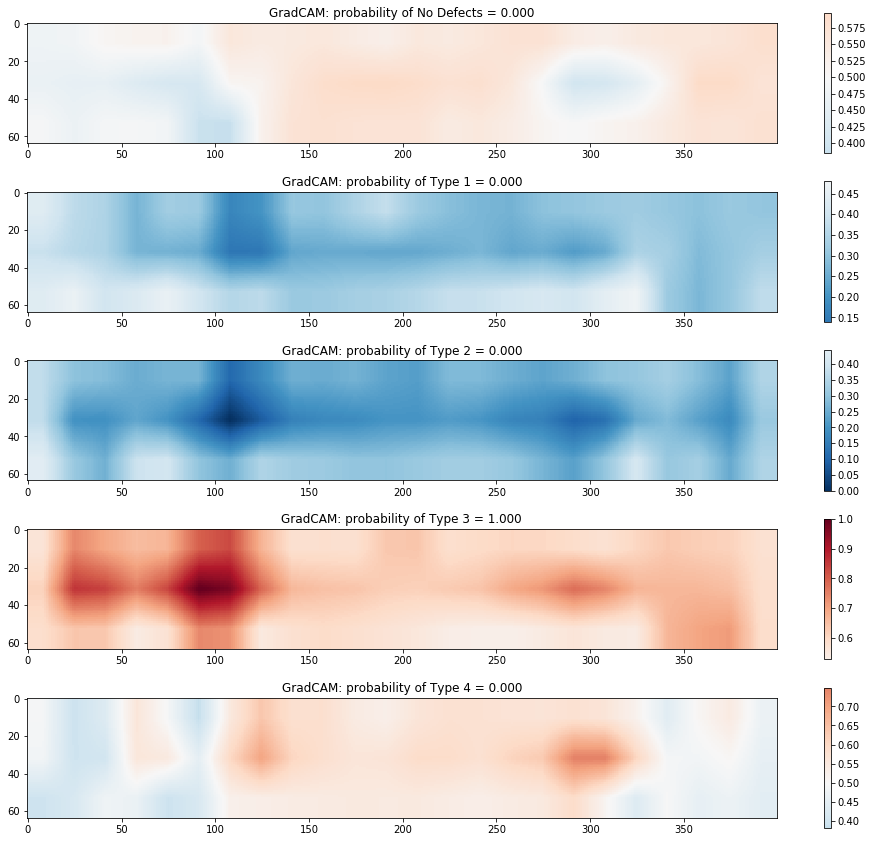

The model predicted correctly:	True


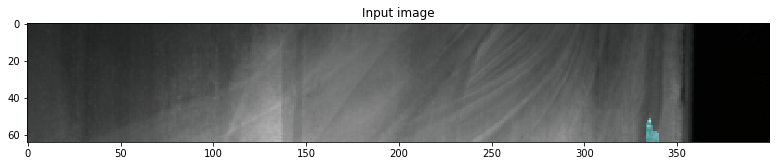

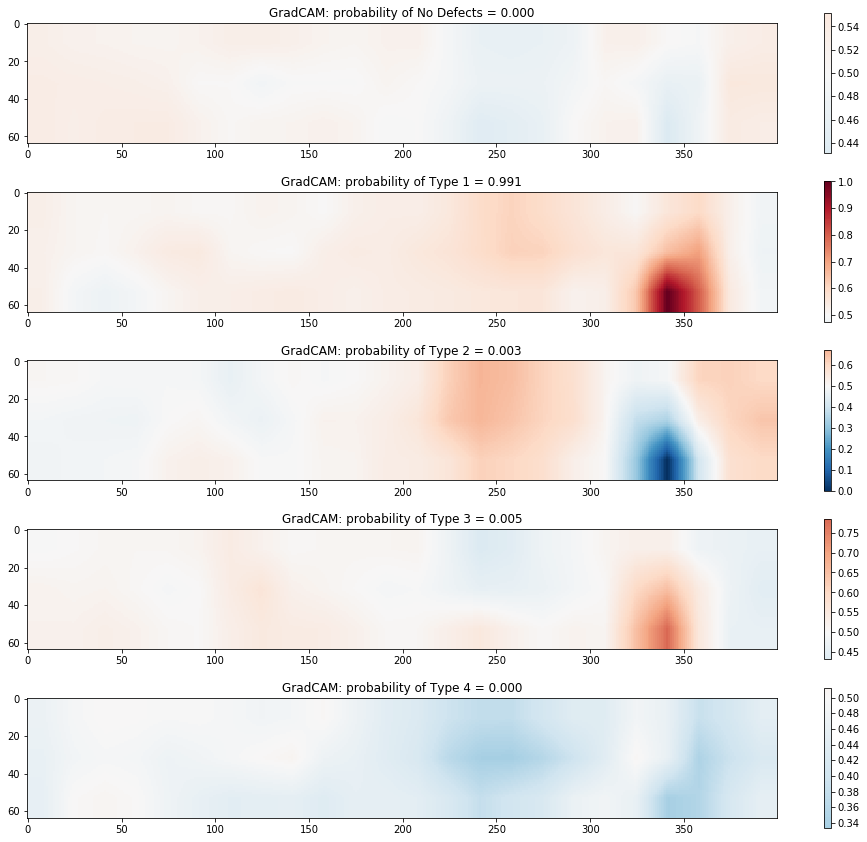

In [19]:
for n in range(10, 20):
    print('The model predicted correctly:\t{}'.format(y_pred[n] == y_true[n]))
    #print('Predicted ClassID {} with probabability:\t{:.2f}'.format(int(y_pred[n], y_score[n, 1]))
    #visualize_input(n)
    visualize_gradcam(n, module = net.classifier[1], normalizer=True, color_normalizer=True)

### DeepSHAP

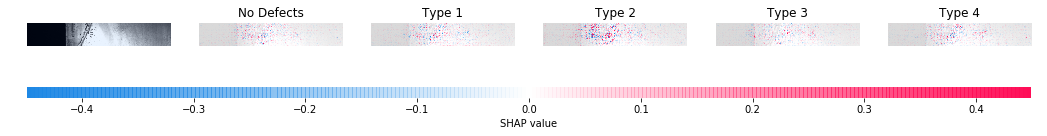

In [11]:
### 7.2.a) Define Backgrund using the next 15 following images in the batch
background = X_test[n+1:n+20].to(device)
### 7.2.b) Init the explainer passing to it the Network and the backgorund
e = shap.GradientExplainer(net.to(device), background)
inp_img = X_test[n].view(1, *list(X_test[n].shape))

### 7.2.c) Compute the shap values for the input X. Input must be 4D (B, C, H, W) and in GPU.
shap_values = e.shap_values(inp_img.to(device)) 

### 7.2.d) Display results
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]                  ### Reshape shap values
test_numpy = np.swapaxes(np.swapaxes(inp_img.cpu().numpy(), 1, -1), 1, 2)                     ### Reshape input example
test_numpy = (test_numpy - test_numpy.min()) / (test_numpy.max() - test_numpy.min())          ### Normalize     
class_labels_shap = np.array([i for i in class_labels.values()]).reshape(1, n_classes)        ### Define Class Labels
shap.image_plot(shap_numpy, test_numpy, class_labels_shap)#, figsize = (20, 5))                 ### Plot

The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished


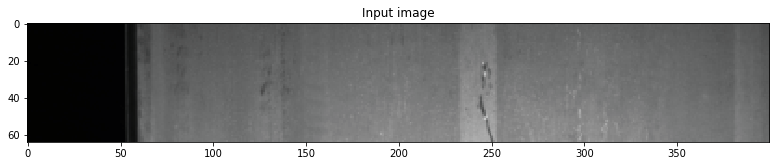

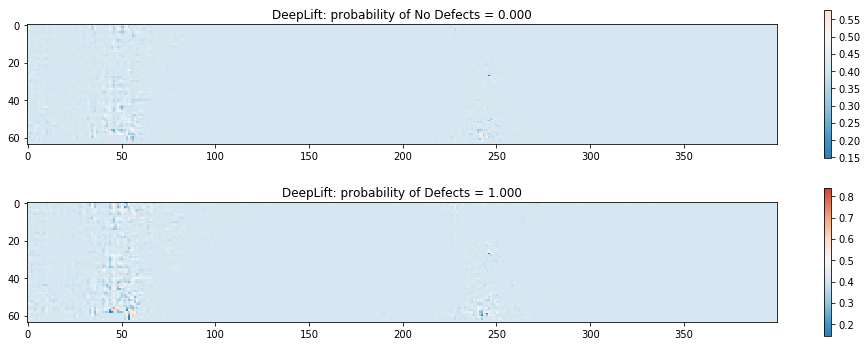

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


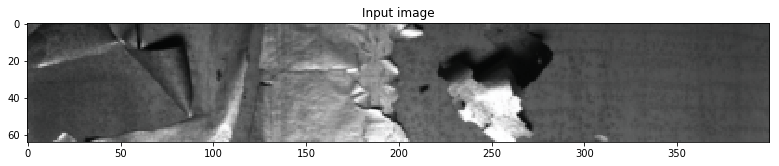

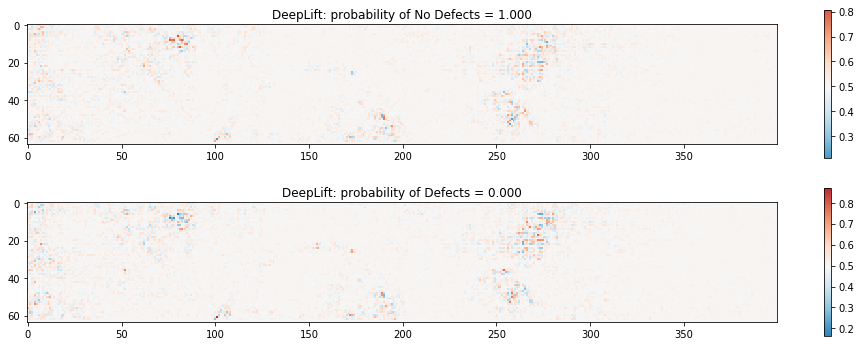

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


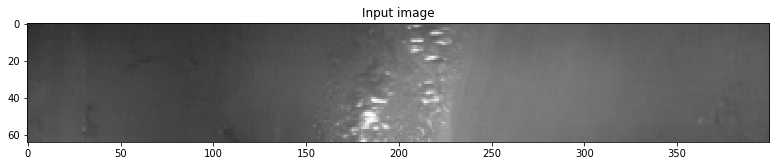

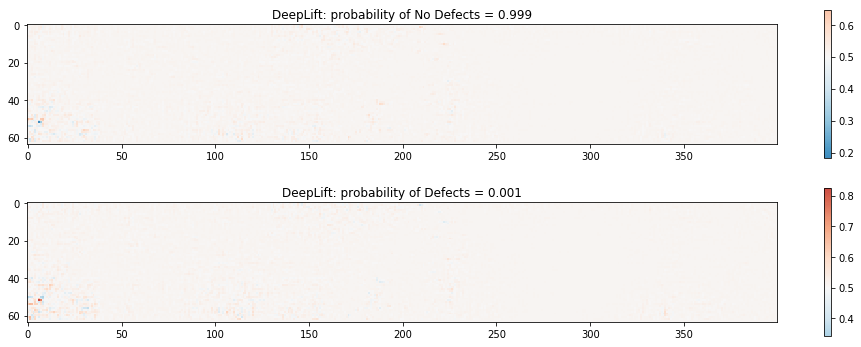

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	0.86
Predicted Defects with probabability:	0.14


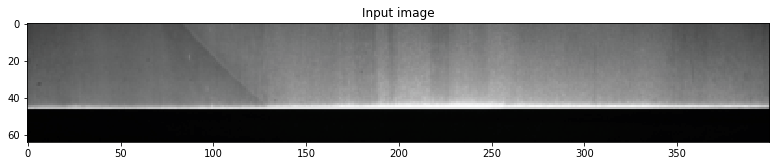

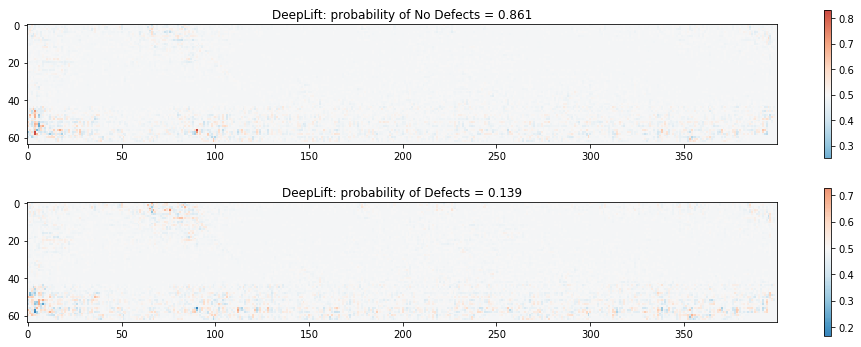

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


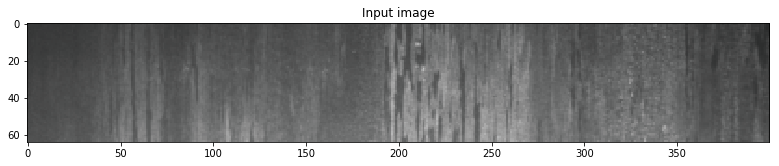

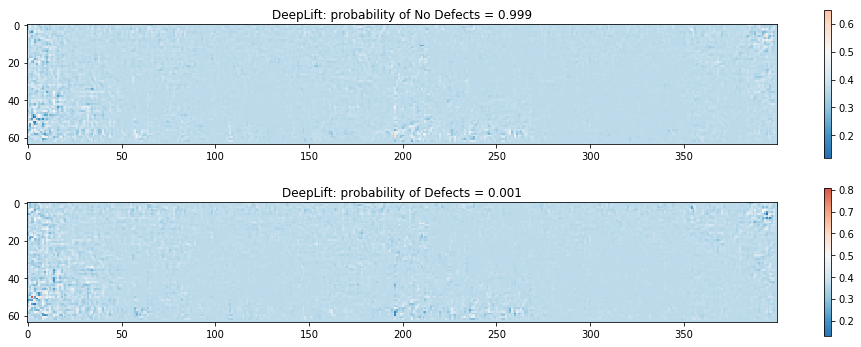

The model predicted correctly:	True
Predicted No Defects with probability:	0.74
Predicted Defects with probabability:	0.26


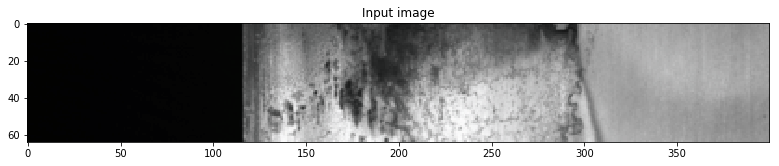

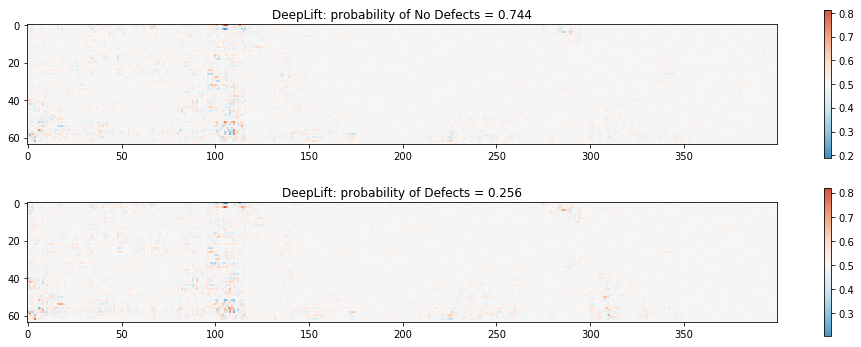

The model predicted correctly:	True
Predicted No Defects with probability:	0.05
Predicted Defects with probabability:	0.95


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


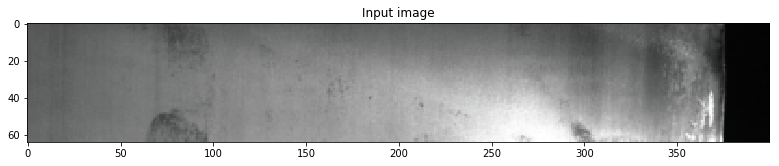

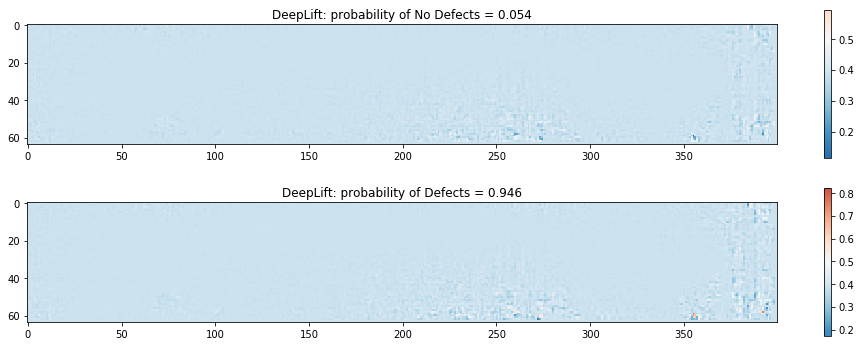

The model predicted correctly:	True
Predicted No Defects with probability:	1.00
Predicted Defects with probabability:	0.00


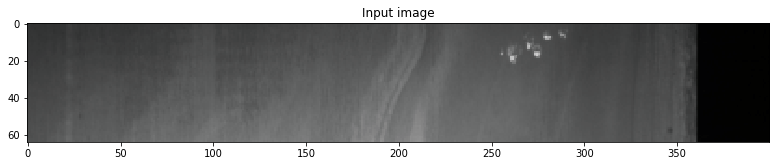

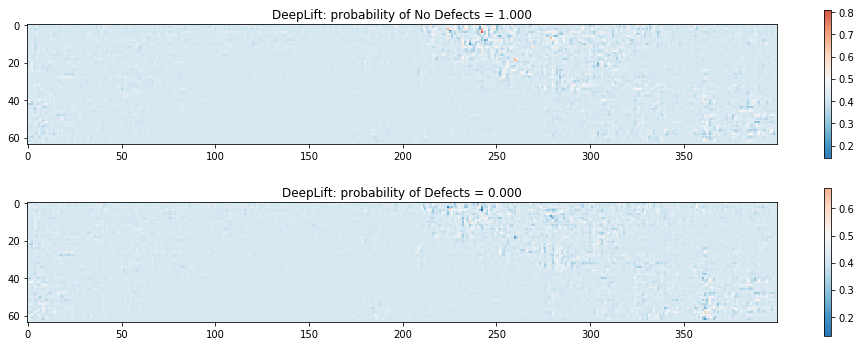

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model predicted correctly:	True
Predicted No Defects with probability:	0.00
Predicted Defects with probabability:	1.00


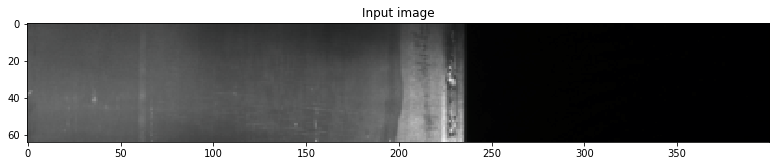

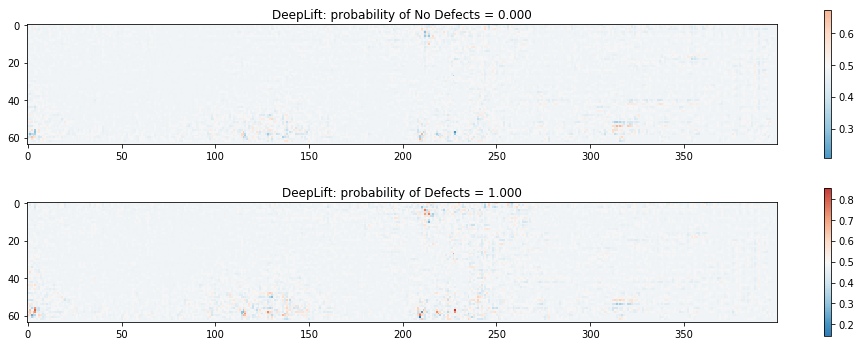

The model predicted correctly:	True
Predicted No Defects with probability:	0.10
Predicted Defects with probabability:	0.90


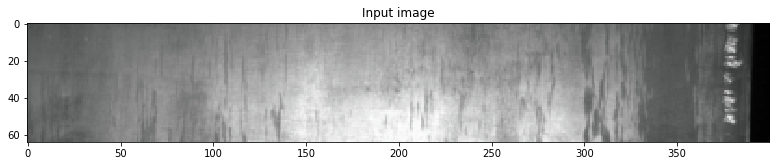

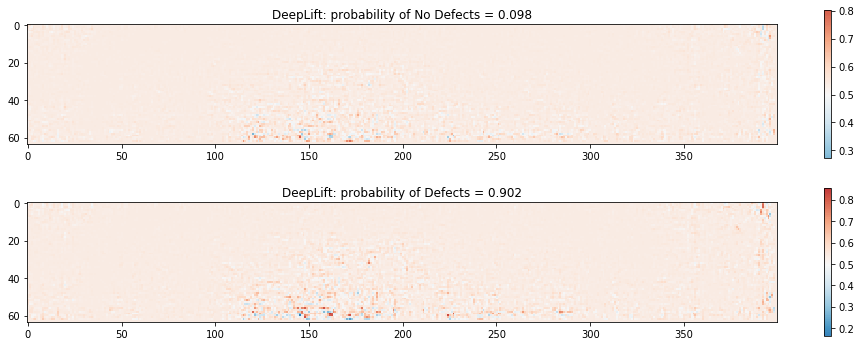

In [16]:
for n in range(10, 20):
    print('The model predicted correctly:\t{}'.format(y_pred[n] == y_true[n]))
    print('Predicted No Defects with probability:\t{:.2f}'.format(y_score[n, 0]))
    print('Predicted Defects with probabability:\t{:.2f}'.format(y_score[n, 1]))
    #visualize_input(n)
    visualize_deeplift(n, normalizer=True, color_normalizer=True)